In [6]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
!pip install openpyxl

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input/sinyal-gsr-1/Sinyal Sensor Polar HR HRV ECG.xlsx'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/tmp/ipykernel_30/1867927398.py:35: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  y = data['label'].replace({'bugar': 0, 'lelah': 1}).astype(int)


Epoch 1/200
68/68 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - accuracy: 0.6426 - loss: 0.8118 - val_accuracy: 0.6188 - val_loss: 0.6661 - learning_rate: 0.0010
Epoch 2/200
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.7256 - loss: 0.5965 - val_accuracy: 0.6703 - val_loss: 0.6472 - learning_rate: 0.0010
Epoch 3/200
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.7202 - loss: 0.5743 - val_accuracy: 0.7385 - val_loss: 0.6145 - learning_rate: 0.0010
Epoch 4/200
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.7519 - loss: 0.5247 - val_accuracy: 0.7514 - val_loss: 0.5657 - learning_rate: 0.0010
Epoch 5/200
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.7260 - loss: 0.5372 - val_accuracy: 0.7956 - val_loss: 0.4930 - learning_rate: 0.0010
Epoch 6/200
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.7645 - loss: 0.4943 - val_accuracy: 0.8011 - val_loss: 0.4480 - learning_rate: 0.0010
Epoch 7/200
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.7464 - loss: 0.5032 - val_ac

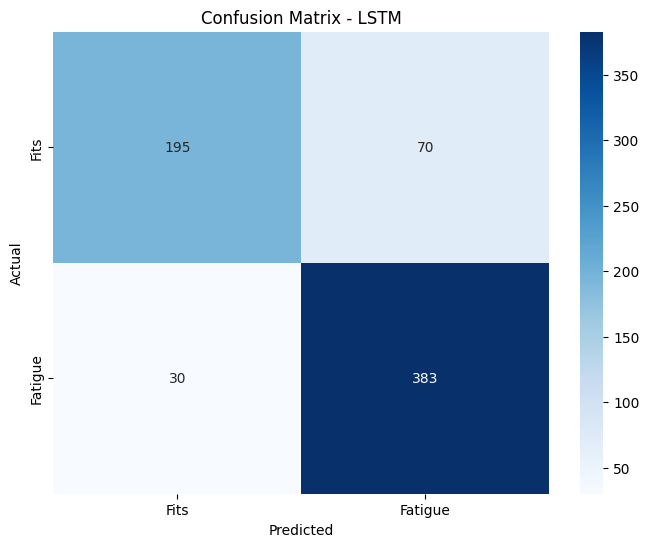

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


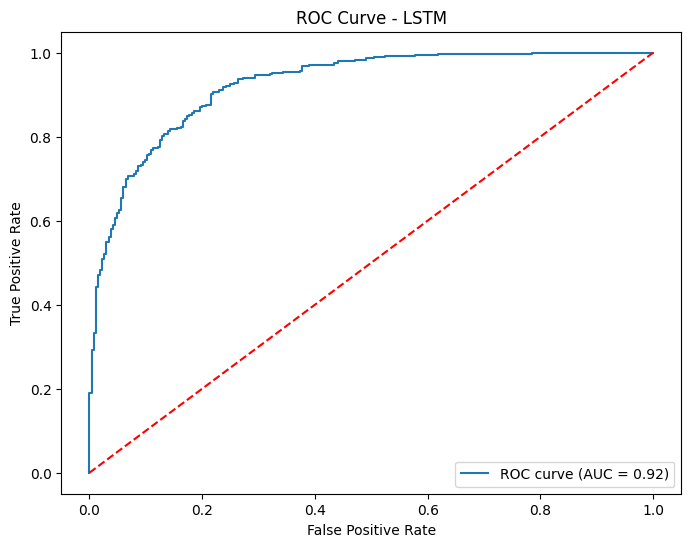

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step

Predicted condition: fits (Confidence: 1.00)


/opt/conda/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but SimpleImputer was fitted with feature names
  warnings.warn(


In [8]:
# LSTM 85,55% 
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, BatchNormalization, Input, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam

# Load dataset
data = pd.read_excel('/kaggle/input/gsr-data-bersih/data_bersih_gsr.xlsx')

# Preprocessing: Separate features and labels
X = data[['HR [bpm]', 'HRV [ms]', 'RR-interval [ms]', 'ecg [uV]']].copy()

# Add statistical features from ECG with a smaller window
window_size = 5
X['ecg_mean'] = X['ecg [uV]'].rolling(window=window_size, min_periods=1).mean()
X['ecg_std'] = X['ecg [uV]'].rolling(window=window_size, min_periods=1).std()
X['ecg_min'] = X['ecg [uV]'].rolling(window=window_size, min_periods=1).min()
X['ecg_max'] = X['ecg [uV]'].rolling(window=window_size, min_periods=1).max()

# Additional advanced features
X['HR_HRV_ratio'] = X['HR [bpm]'] / X['HRV [ms]'].replace(0, np.nan)
X['HR_RR_ratio'] = X['HR [bpm]'] / X['RR-interval [ms]'].replace(0, np.nan)
X['ecg_range'] = X['ecg_max'] - X['ecg_min']

# Label (fits or fatigue) with mapping
y = data['label'].replace({'bugar': 0, 'lelah': 1}).astype(int)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Impute and scale data
imputer = SimpleImputer(strategy='median')
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

scaler = PowerTransformer()
X_train_scaled = scaler.fit_transform(X_train_imputed)
X_test_scaled = scaler.transform(X_test_imputed)

# Reshape data for LSTM
X_train_lstm = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_test_lstm = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

# One-hot encode labels
y_train_encoded = to_categorical(y_train)
y_test_encoded = to_categorical(y_test)

# Build LSTM model
def create_lstm_model(input_shape, units=128, dropout_rate=0.5, learning_rate=0.001):
    model = Sequential([
        Input(shape=input_shape),
        Bidirectional(LSTM(units, return_sequences=True)),
        BatchNormalization(),
        Dropout(dropout_rate),
        Bidirectional(LSTM(units // 2, return_sequences=False)),
        BatchNormalization(),
        Dropout(dropout_rate),
        Dense(64, activation='relu'),
        Dropout(dropout_rate / 2),
        Dense(2, activation='softmax')
    ])
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Train the LSTM model
lstm_model = create_lstm_model(input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2]))
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)

history = lstm_model.fit(
    X_train_lstm, y_train_encoded,
    epochs=200, batch_size=32, validation_split=0.2,
    callbacks=[early_stopping, reduce_lr], verbose=1
)

# Evaluate LSTM model
lstm_loss, lstm_accuracy = lstm_model.evaluate(X_test_lstm, y_test_encoded)
print(f"LSTM Model Accuracy: {lstm_accuracy * 100:.2f}%")

# Evaluate LSTM model
lstm_predictions = np.argmax(lstm_model.predict(X_test_lstm), axis=1)
lstm_conf_matrix = confusion_matrix(y_test, lstm_predictions)

print("\nLSTM Classification Report:")
print(classification_report(y_test, lstm_predictions))

# Display Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(lstm_conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Fits', 'Fatigue'], yticklabels=['Fits', 'Fatigue'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - LSTM')
plt.show()

# AUROC for LSTM
lstm_probabilities = lstm_model.predict(X_test_lstm)[:, 1]
fpr_lstm, tpr_lstm, _ = roc_curve(y_test, lstm_probabilities)
roc_auc_lstm = roc_auc_score(y_test, lstm_probabilities)

plt.figure(figsize=(8, 6))
plt.plot(fpr_lstm, tpr_lstm, label=f'ROC curve (AUC = {roc_auc_lstm:.2f})')
plt.plot([0, 1], [0, 1], 'r--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - LSTM')
plt.legend(loc='lower right')
plt.show()

# Function for real-time prediction
def predict_real_time(hr_bpm, hrv_ms, rr_interval_ms, ecg_values):
    # Calculate ECG features
    ecg_mean = np.mean(ecg_values)
    ecg_std = np.std(ecg_values)
    ecg_min = np.min(ecg_values)
    ecg_max = np.max(ecg_values)
    ecg_range = ecg_max - ecg_min
    hr_hrv_ratio = hr_bpm / hrv_ms if hrv_ms != 0 else np.nan
    hr_rr_ratio = hr_bpm / rr_interval_ms if rr_interval_ms != 0 else np.nan
    
    # Create input data with the same features as used in training
    input_data = np.array([[
        hr_bpm, hrv_ms, rr_interval_ms, ecg_values[-1],
        ecg_mean, ecg_std, ecg_min, ecg_max,
        hr_hrv_ratio,
        hr_rr_ratio,
        ecg_range
    ]])
    
    # Impute missing values
    input_imputed = imputer.transform(input_data)
    
    # Scale input data
    input_scaled = scaler.transform(input_imputed)
    
    # Make predictions using LSTM
    lstm_input = input_scaled.reshape((1, 1, input_scaled.shape[1]))
    lstm_pred = lstm_model.predict(lstm_input)
    
    label_idx = np.argmax(lstm_pred, axis=1)
    label = ['fits', 'fatigue'][label_idx[0]]
    confidence = lstm_pred[0, label_idx[0]]
    
    return label, confidence

# Example usage of real-time prediction
ecg_values_example = [2737, 2188, 2354, 2312, 2060]
result, confidence = predict_real_time(114, 34, 1047, ecg_values_example)
print(f'\nPredicted condition: {result} (Confidence: {confidence:.2f})')